#### libaray

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.2 MB/s eta 0:00:00


In [3]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.9 MB/s eta 0:00:00


In [4]:
import jax
import jax.numpy as jnp
import numpy as np

import einops
from scipy.spatial.distance import pdist
from scipy.spatial import ckdtree
# from jax import grad

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from google.colab import widgets

import plotly.graph_objects as go
from tqdm import tqdm
import pickle

from shapely.geometry.polygon import Polygon
import shapely

from typing import Any, Callable, Tuple, Union
Array = Union[np.ndarray, jnp.DeviceArray]

In [5]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

In [6]:
%load_ext autotime

time: 380 µs (started: 2023-01-24 20:37:48 +00:00)


#### global plotting parameters

In [7]:
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
matplotlib.rcParams.update({'font.size': 12})

time: 1.9 ms (started: 2023-01-24 20:37:48 +00:00)


In [8]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

time: 1.02 ms (started: 2023-01-24 20:37:48 +00:00)


In [9]:
# matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

time: 414 µs (started: 2023-01-24 20:37:48 +00:00)


## Define functions

In [33]:

from collections import Counter
Counter(["X", "Z"]) 

Counter({'X': 1, 'Z': 1})

time: 8.41 ms (started: 2023-01-24 22:08:22 +00:00)


In [28]:
array = np.arange(5)
np.random.shuffle(array)
array

array([1, 4, 2, 0, 3])

time: 5.26 ms (started: 2023-01-24 21:56:25 +00:00)


In [30]:
array = np.arange(5)
rng = np.random.default_rng()
rng.shuffle(array)
array

array([2, 3, 1, 4, 0])

time: 13.1 ms (started: 2023-01-24 21:56:33 +00:00)


In [13]:
def elemetntaryLoop(type, anchor):
  """
  Generate coordinates for a pair of triangles (t1, t2), boundary bonds coordinates, and middle bond coordinates.
  `type` is the type of the elementry loop, `anchor` is an array, the coordinate of a chosen vertex
  """
  anchor = np.array(anchor)
  height = np.sqrt(3)/2
  if type == 0:
    t1 = anchor + np.array([0, 2 / 3 * np.sqrt(3)/2])   # triangles
    t2 = anchor + np.array([1 / 2, 1 / 3 * np.sqrt(3)/2])
    bd_vs = anchor + np.array([
        [[0, 0], [1, 0]],
        [[1, 0], [1/2, height]],
        [[1/2, height], [-1/2, height]],
        [[-1/2, height], [0, 0]]
        ])
    mid_vs = anchor + np.array([
        [[0, 0], [1/2, height]]
    ])
    bd_ps = np.mean(bd_vs, axis=1, keepdims=False)
    bd_signs = np.array([
        1, 1, -1, -1
        # [1], [1], [-1], [-1]
        ])
  if type == 1:
    t1 = anchor + np.array([1 / 2, 1 / 3 * np.sqrt(3)/2])
    t2 = anchor + np.array([1, 2 / 3 * np.sqrt(3)/2])
    bd_vs = anchor + np.array([
        [[0, 0], [1, 0]],
        [[0, 0], [1/2, height]],
        [[1, 0], [3/2, height]], 
        [[1/2, height], [3/2, height]]
    ])      # boundary vertices
    mid_vs = anchor + np.array([
        [[1, 0], [1/2, height]]
    ])
    bd_ps = np.mean(bd_vs, axis=1, keepdims=False)
    bd_signs = np.array([
        1, -1, 1, -1
        # [1], [1], [-1], [-1]
        ]
    )
  if type == 2:
    t1 = anchor + np.array([1 / 2, 1 / 3 * np.sqrt(3)/2])
    t2 = anchor + np.array([1 / 2, -1 / 3 * np.sqrt(3)/2])
    bd_vs = anchor + np.array([
        [[0., 0.], [1./2., - height]],
        [[1./2., - height], [1., 0.]],
        [[1., 0.], [1./2., height]], 
        [[1./2., height], [0., 0.]]
    ])      # boundary vertices
    mid_vs = anchor + np.array([
        [[0, 0], [1, 0]]
    ])
    bd_ps = np.mean(bd_vs, axis=1, keepdims=False)
    bd_signs = np.array([
        -1, 1, 1, -1
        # [1], [1], [-1], [-1]
        ]
    ) 
  return {"triangles":np.array([t1, t2]), "bd_vs": np.around(bd_vs, 2), "mid_vs": np.around(mid_vs, 2), "bs_ps":np.around(bd_ps, 2), "bd_signs":bd_signs}

time: 6.21 ms (started: 2023-01-24 17:20:49 +00:00)


In [14]:
def create_grid_mesh(params, bases=[(0, 0)]):
  x1 = params['x1']
  x2 = params['x2']
  y1 = params['y1']
  y2 = params['y2']
  Nx = params['Nx']
  Ny = params['Ny']

  spacing_x = (x2 - x1) / (Nx)
  spacing_y = (y2 - y1) / (Ny)
  x_grid = np.linspace(x1, x2 - spacing_x, Nx)
  y_grid = np.linspace(y1, y2 - spacing_y, Ny)

  #create a mesh
  X, Y = np.meshgrid(x_grid, y_grid)

  return X, Y

def create_grid(params):

  #create a mesh
  my_x, my_y = create_grid_mesh(params)
  a1 = params['a1']
  a2 = params['a2']
  #stack the mesh to (Nx, Ny, d=2) dim
  # print(my_x.shape)
  # my_grid = np.stack([my_x * a1 + my_y * a2], axis=-1)
  my_grid = np.stack([my_x, my_y], axis=-1)
  # print(my_grid.shape)

  my_grid = einops.rearrange(my_grid, 'x y d -> (x y) d') #integer grid

  return np.tensordot(my_grid[:, 0], a1, 0) + np.tensordot(my_grid[:, 1], a2, 0)

time: 3.77 ms (started: 2023-01-24 17:20:49 +00:00)


In [15]:
def check_merge(loop, eb):
  """
  This function checks if we should merge the two ojects L and eb. 
  `loop` is a general loop.
  `eb` is an elementary bond, where there are four boundaries. 
  """
  def _check_common_coord(a, b):
    # Takes two arrays a_ij and b_kj each 2d array with last common dimension j (=2 for our case).
    # Return the absolute of the sum of the difference for each pairs (ik)
    dim_a = a.shape[0]
    dim_b = b.shape[0]
    a = np.around(a, 2)
    b = np.around(b, 2)
    a2 = einops.repeat(a, 'a b -> a new_axis b ', new_axis=dim_b)
    b2 = einops.repeat(b, 'a b -> new_axis a b', new_axis=dim_a)
    return np.sum(np.abs(einops.rearrange(a2 - b2, 'a b c -> (a b)c')), axis=1)
  
  def _merge_loops(loop, eb):
    """
    Merge loop and eb: remove repeated bd_v and add that to `mid_vs`.
    """
    loop_merge = jax.tree_util.tree_map(lambda x, y: np.concatenate([x, y], axis=0), loop, eb)
    bd_vs = loop_merge["bd_vs"]
    mid_vs = loop_merge["mid_vs"]
    bd_signs = loop_merge["bd_signs"]
    bd = np.mean(bd_vs, axis=1, keepdims=False)
    # middle = np.mean(mid_vs, axis=1, keepdims=False)
    unq, count = np.unique(bd, axis=0, return_counts=True)
    # print(unq, count)
    repeated_ars = unq[count>1]
    repeated_indices = [np.argwhere(np.all(bd == repeated_ar, axis=1)) for repeated_ar in repeated_ars]
    # for repeated_ar in repeated_ars:
    #   repeated_idx = np.argwhere(np.all(bd == repeated_ar, axis=1))   # Find which the index of the pairs that is repeated
    #   repeated_indices.append()
    repeated_idx_flatten = np.ndarray.flatten(np.array(repeated_indices))
    repeated_idx_sorted = sorted(repeated_idx_flatten, reverse=True) 
    for repeated_idx in repeated_idx_sorted:
      bd_vs = np.delete(bd_vs, repeated_idx, axis=0)    # new boundary vertices
      bd_ps = np.mean(bd_vs, axis=1, keepdims=False)    # new boundary points
      bd_signs = np.delete(bd_signs, repeated_idx, axis=0)    # new boundary bd_signs
      # repeated_idx = einops.repeat(repeated_idx, 'a b -> a (repeat b)', repeat=2)
      # repeated_idx = einops.repeat(repeated_idx, 'a b -> a b c', c=2)
      # repeated_bd_v = np.take_along_axis(bd_vs, repeated_idx, axis=0)
      # repeated_vs_unq = np.unique(repeated_bd_v, axis=0, return_counts=False)


      # print(repeated_bd_v.shape)
      # print(mid_vs.shape)
      # repeated_bd_v = bd_vs[repeated_idx]
      # repeated_ar = einops.rearrange(repeated_bd_v, 'b c-> 1 b c')
      # print(repeated_bd_v)
      # print(f"the repeated vs are {repeated_bd_v}")
      
      # print(f"the unique repeated vs are {repeated_vs_unq}")
      # print(repeated_vs_unq)
      # print(repeated_ar.shape)
      # mid_vs = np.concatenate([mid_vs, repeated_vs_unq], axis=0)    #todo: finish marging mid_vs
    return {"bd_vs": bd_vs, "mid_vs": mid_vs, "triangles": loop_merge["triangles"], "bs_ps":bd_ps, "bd_signs":bd_signs}    

  t_l = loop["triangles"]
  t_eb = eb["triangles"]
  bd_vs_l = loop["bd_vs"]
  bd_vs_eb = eb["bd_vs"]
  boundaries_l = np.mean(bd_vs_l, axis=1, keepdims=False)
  boundaries_eb = np.mean(bd_vs_eb, axis=1, keepdims=False)

  t_diff = _check_common_coord(t_l, t_eb) # sum abs difference in the pairs of coordinates 
  if t_diff.shape[0] > np.count_nonzero(t_diff):  # if there are zeroes (overlapping triangles)
    return False, {}
  else:
    boundaries_diff = _check_common_coord(boundaries_l, boundaries_eb)
    if boundaries_diff.shape[0] == np.count_nonzero(boundaries_diff):    # if there are no zeroes (overlapping boundaries)
      return False, {}
    else:
      # if (boundaries_diff.shape[0] - np.count_nonzero(boundaries_diff)) % 2 == 0:
      merge_loop = _merge_loops(loop, eb)
      return True, merge_loop
      # else:
      #   return False, {}

time: 6.18 ms (started: 2023-01-24 17:20:49 +00:00)


In [16]:
def _plot_v_bonds(ax, v_pairs, c='b'):
  # helper function for plotting pairs of bonds
  for i, v_pair in enumerate(v_pairs):
    if isinstance(c, np.ndarray):
      ax.plot(v_pair[:, 0], v_pair[:, 1], color=c[i])
    else:
      ax.plot(v_pair[:, 0], v_pair[:, 1], color=c)

def _plot_visons(ax, v_pairs, Q_gs, Q_vison, c='b', p=1.):
  # helper function for plotting pairs of bonds
  shift_x = 0.05
  for i, v_pair in enumerate(v_pairs):
    Q0 = Q_gs[i]
    Qv = Q_vison[i]
    diff = np.around(Qv - Q0, 2)
    thickness = np.sqrt(np.abs(Qv-Q0))
    v_mid = np.around(np.mean(v_pair, axis=0), 3)
    if isinstance(c, np.ndarray):
      ax.plot(v_pair[:, 0], v_pair[:, 1], color=c[i], linewidth=p * thickness)
    else:
      ax.plot(v_pair[:, 0], v_pair[:, 1], color=c, linewidth=p * thickness)
      ax.annotate(diff, (v_mid[0]+ shift_x, v_mid[1]), color='r')
  

time: 5.02 ms (started: 2023-01-24 17:20:49 +00:00)


In [17]:
def condensed_to_pair_indices(n,k):
    x = n-(4.*n**2-4*n-8*k+1)**.5/2-.5
    i = x.astype(int)
    j = k+i*(i+3-2*n)/2+1
    return i.astype(int),j.astype(int)
def close_pairs_pdist(X, max_d):
    d = pdist(X)
    k = (d<max_d).nonzero()[0]
    # return k
    return condensed_to_pair_indices(X.shape[0],k)    

def build_dict_bonds(bonds):
  bonds = np.around(bonds, 2)
  bonds2 = np.flip(bonds, 1)
  length = bonds.shape[0]
  keys = list(bonds)
  keys2 = list(bonds2)
  dict_bonds = {(keys[i]).tobytes(): i for i in np.arange(length).astype(int)}
  dict_bonds2 = {(keys2[i]).tobytes(): i for i in np.arange(length).astype(int)}
  return {**dict_bonds, **dict_bonds2}

time: 2.87 ms (started: 2023-01-24 17:20:49 +00:00)


In [18]:
def get_energy(couplings, Q, Q0, loops, bonds_dict):
  alpha = couplings["alpha"]
  beta = couplings["beta"]
  K = couplings["K"]
  Qs = Q0 * Q
  Qs_loops_vals = []
  for l in loops:
    bd_vs = l["bd_vs"]
    bd_signs = l["bd_signs"]
    bd_vs = np.around(bd_vs, 2)
    
    indices = np.array([bonds_dict[bd_v.tobytes()] for bd_v in bd_vs])
    Qs_loop = np.take_along_axis(Qs, indices, 0)
    # signs_loop = np.take_along_axis(bd_signs, indices, 0)
    Qs_loops_vals.append(np.prod(Qs_loop * bd_signs))
  Q_quad = np.sum(np.abs(Qs)**2)
  Q_quarc = np.sum(np.abs(Qs)**4)
  return - alpha * Q_quad - beta / 2 * Q_quarc + K * sum(Qs_loops_vals)


time: 1.99 ms (started: 2023-01-24 17:20:49 +00:00)


## Test - small grid

### Lattice

In [21]:
mesh

(array([[0., 1.],
        [0., 1.],
        [0., 1.]]), array([[0., 0.],
        [1., 1.],
        [2., 2.]]))

time: 12.6 ms (started: 2023-01-24 17:46:46 +00:00)


In [22]:
grid_params = {'x1':0, 'x2':4, 'y1':0, 'y2':3, 'Nx':4, 'Ny':3, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2])}
mesh = create_grid_mesh(grid_params)
BZ_kpoints = create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

time: 12.4 ms (started: 2023-01-24 17:48:09 +00:00)


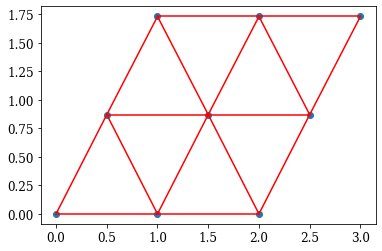

time: 313 ms (started: 2022-10-25 16:46:13 +00:00)


In [ ]:
# find all bonds
my_points = close_pairs_pdist(BZ_kpoints, 1.1)
bonds = BZ_kpoints[np.stack(my_points).T]
bonds = np.around(bonds, 2)

fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
_plot_v_bonds(ax, bonds, c='r')


In [ ]:
bonds_dict = build_dict_bonds(bonds)

time: 2.39 ms (started: 2022-10-25 16:46:13 +00:00)


In [ ]:
test_key = np.around((np.array([[2., 0.], [1., 0.]])), 2)
print(test_key)
bonds_dict[test_key.tobytes()]

[[2. 0.]
 [1. 0.]]


2

time: 10.1 ms (started: 2022-10-25 16:46:13 +00:00)


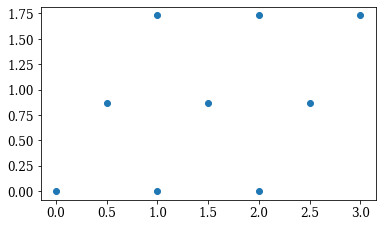

time: 242 ms (started: 2022-10-25 16:46:13 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")


### Loops - small grid

In [ ]:
#@title create all elementry bonds
grid_params_eb = {'x1':0, 'x2':2, 'y1':0, 'y2':2, 'Nx':2, 'Ny':2, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2])}
points_eb1 = list(create_grid(grid_params_eb))
points_eb0 = list(np.array([[1., 0.], [3./2., np.sqrt(3)/2.]]))
points_eb2 = list(np.array([[1./2., np.sqrt(3)/2.], [3./2., np.sqrt(3)/2.]]))
ListEBs0 = [elemetntaryLoop(0, p) for p in points_eb0]
ListEBs1 = [elemetntaryLoop(1, p) for p in points_eb1]
ListEBs2 = [elemetntaryLoop(2, p) for p in points_eb2]
ListEB_comb = [ListEBs0, ListEBs1, ListEBs2]
ListEBs = sum(ListEB_comb, [])

time: 6.97 ms (started: 2022-10-25 16:47:51 +00:00)


In [ ]:
All_loops = []
for eb in tqdm(ListEBs):
  All_loops.append(eb)
  for l in All_loops:
    merge, new_l = check_merge(eb, l)
    if merge:
      All_loops.append(new_l)

100%|██████████| 8/8 [00:00<00:00, 258.35it/s]

time: 48.8 ms (started: 2022-10-25 16:47:51 +00:00)


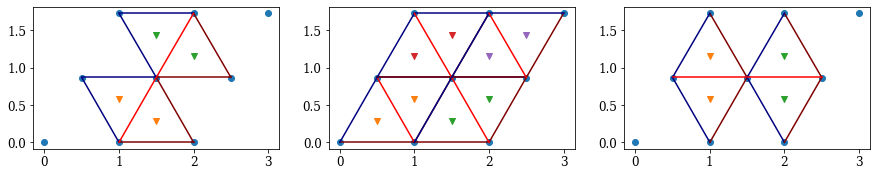

time: 482 ms (started: 2022-10-25 16:47:51 +00:00)


In [ ]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    _plot_v_bonds(ax, bd_vs, c=c)
    _plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

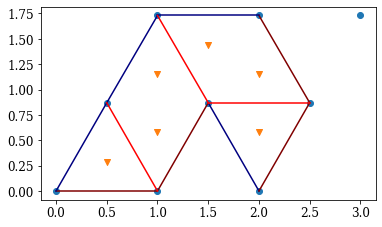

time: 186 ms (started: 2022-10-25 16:47:51 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [All_loops[26]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

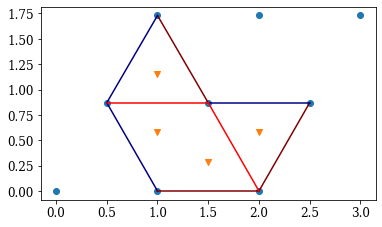

time: 178 ms (started: 2022-10-25 16:47:51 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [All_loops[19]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds))
energy_Q = lambda Q0: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

time: 1.43 ms (started: 2022-10-25 16:48:51 +00:00)


In [ ]:
Q0 = 0.1
results_gs = minimize(energy_Q, Q0)

time: 55.9 ms (started: 2022-10-25 16:48:51 +00:00)


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-5.333333333333332
True
Optimization terminated successfully.
0


array([0.81649657])

time: 12.5 ms (started: 2022-10-25 16:48:53 +00:00)


In [ ]:
height = np.sqrt(3)/2
visonBonds_vs = [np.array([[1.5, height], [2., 0.]]), 
              np.array([[2., 0.], [2.5, height]])]
visonBonds_idx = []
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  visonBonds_idx.append(idx)

time: 1.43 ms (started: 2022-10-25 16:48:55 +00:00)


In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds))
Q0 = results_gs['x']
# Q0 = 0.1
for idx in visonBonds_idx:
  Q_init[idx] = -1
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
results_vison = minimize(energy_Q, Q_init)

time: 338 ms (started: 2022-10-25 16:48:59 +00:00)


In [ ]:
energy_Q(Q_init)

-4.444444478922292

time: 8.37 ms (started: 2022-10-25 16:49:00 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-4.677785048956531
True
Optimization terminated successfully.
0


array([ 0.92926268,  0.92926278,  0.67862417,  0.8935557 ,  0.94766109,
       -0.89172623, -0.88920909,  0.95839385,  0.98977982,  0.95870534,
        0.98751703,  1.03007948,  0.98635222,  0.93458216,  0.99501912,
        0.93458231])

time: 9.06 ms (started: 2022-10-25 16:49:01 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 1.19 ms (started: 2022-10-25 16:49:03 +00:00)


In [ ]:
Qv_results -  results_gs['x'] * np.ones(len(bonds))

array([ 0.11276611,  0.11276621, -0.13787241,  0.07705913,  0.13116452,
       -1.7082228 , -1.70570567,  0.14189728,  0.17328325,  0.14220877,
        0.17102045,  0.2135829 ,  0.16985565,  0.11808559,  0.17852255,
        0.11808573])

time: 4.07 ms (started: 2022-10-25 16:49:05 +00:00)


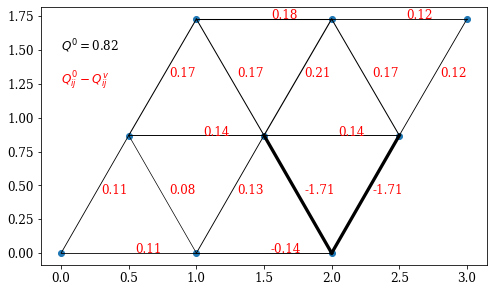

time: 450 ms (started: 2022-10-25 16:49:06 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  # triangles = np.split(eb['triangles'], 2, axis=1)
  # bd_vs = eb['bd_vs']
  # mid_vs = eb['mid_vs']
  # bd_signs = eb['bd_signs']
  
  # colors = plt.cm.jet(np.linspace(0,1,2))
  # bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # # print(bd_signs_idx)
  # c = colors[bd_signs_idx]
  # ax.scatter(triangles[0], triangles[1], marker='v')
  # _plot_v_bonds(ax, bd_vs, c=c)
  _plot_visons(ax, bond, Q0_results, Qv_results, c='k', p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 1.5))
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

## Test - large grid

In [ ]:
def create_grid_mesh(params):
  """
  Create a mesh grid of the regtangular grid (nx, ny) (in units of lattice vectors v = nx a_x + ny a_y)
  """
  kx1 = params['x1']
  kx2 = params['x2']
  ky1 = params['y1']
  ky2 = params['y2']
  Nx = params['Nx']
  Ny = params['Ny']
  origin_shift = params['O']

  spacing_x = (kx2 - kx1) / (Nx)
  spacing_y = (ky2 - ky1) / (Ny)
  kx_grid = np.linspace(kx1, kx2 - spacing_x, Nx) + origin_shift[0]   #x grid with shift of ny (not y!)
  ky_grid = np.linspace(ky1, ky2 - spacing_y, Ny) + origin_shift[1]

  #create a mesh
  X, Y = np.meshgrid(kx_grid, ky_grid)

  return X, Y

def create_grid(params):
  """
  Create a mesh grid of the lattice grid (vx, vy) 
  """
  #create a mesh
  my_x, my_y = create_grid_mesh(params)
  a1 = params['a1']
  a2 = params['a2']
  #stack the mesh to (Nx, Ny, d=2) dim
  # print(my_x.shape)
  # my_grid = np.stack([my_x * a1 + my_y * a2], axis=-1)
  my_grid = np.stack([my_x, my_y], axis=-1)
  # print(my_grid.shape)

  my_grid = einops.rearrange(my_grid, 'x y d -> (x y) d') #integer grid

  return np.tensordot(my_grid[:, 0], a1, 0) + np.tensordot(my_grid[:, 1], a2, 0)

time: 6.17 ms (started: 2023-01-10 18:53:36 +00:00)


In [ ]:
grid_params = {'x1':0, 'x2':5, 'y1':0, 'y2':5, 'Nx':5, 'Ny':5, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.)}
create_grid_mesh(grid_params)
BZ_kpoints = create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

time: 9.69 ms (started: 2023-01-10 18:53:37 +00:00)


Text(0.5, 0.98, 'Lattice with N=25 and $N_{\\rm bonds}=$56')

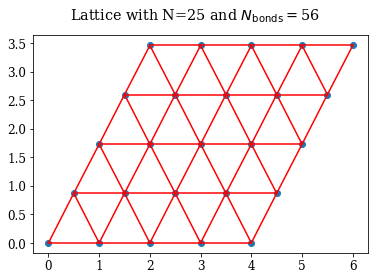

time: 465 ms (started: 2023-01-10 18:53:38 +00:00)


In [ ]:
# find all bonds
my_points = close_pairs_pdist(BZ_kpoints, 1.1)
bonds = BZ_kpoints[np.stack(my_points).T]
bonds = np.around(bonds, 2)

fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
_plot_v_bonds(ax, bonds, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds.shape[0]}")


In [ ]:
bonds_dict = build_dict_bonds(bonds)

time: 1.06 ms (started: 2023-01-10 18:53:40 +00:00)


In [ ]:
test_key = np.around((np.array([[2., 0.], [1., 0.]])), 2)
print(test_key)
bonds_dict[test_key.tobytes()]

[[2. 0.]
 [1. 0.]]


2

time: 10.7 ms (started: 2023-01-10 18:53:40 +00:00)


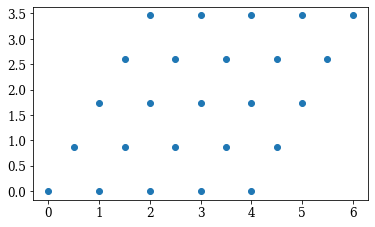

time: 177 ms (started: 2023-01-10 18:53:41 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")


### Loops - large grid

In [ ]:
data_dir = '/content/drive/MyDrive/Projects/RydbergVison/Data/DataColab/'

time: 633 µs (started: 2023-01-10 18:53:46 +00:00)


#### Create elementry bonds

In [ ]:
#@title create all elementry bonds
grid_params_eb = {'x1':0, 'x2':4, 'y1':0, 'y2':4, 'Nx':4, 'Ny':4, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 0.)}
points_eb1 = list(create_grid(grid_params_eb))
grid_params_eb0 = {'x1':0, 'x2':3, 'y1':0, 'y2':4, 'Nx':3, 'Ny':4, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(1., 0.)}
points_eb0 = list(create_grid(grid_params_eb0))
grid_params_eb2 = {'x1':0, 'x2':4, 'y1':0, 'y2':3, 'Nx':4, 'Ny':3, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 1.)}
points_eb2 = list(create_grid(grid_params_eb2))
ListEBs0 = [elemetntaryLoop(0, p) for p in points_eb0]
ListEBs1 = [elemetntaryLoop(1, p) for p in points_eb1]
ListEBs2 = [elemetntaryLoop(2, p) for p in points_eb2]
ListEB_comb = [ListEBs0, ListEBs1, ListEBs2]
ListEBs = sum(ListEB_comb, [])

time: 14 ms (started: 2023-01-10 18:53:47 +00:00)


In [ ]:
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

time: 920 µs (started: 2023-01-10 18:53:47 +00:00)


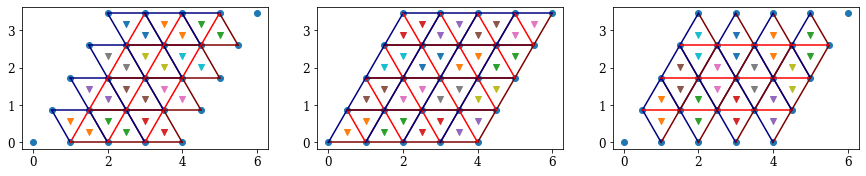

time: 1.02 s (started: 2023-01-10 18:53:47 +00:00)


In [ ]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    _plot_v_bonds(ax, bd_vs, c=c)
    _plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Compute all possible loops
 - Currently have bugs
 

In [ ]:

All_loops = []
for eb in tqdm(ListEBs):
  All_loops.append(eb)
  for l in All_loops:
    merge, new_l = check_merge(eb, l)
    if merge:
      All_loops.append(new_l)

100%|██████████| 40/40 [01:45<00:00,  2.64s/it]

time: 1min 45s (started: 2022-10-25 16:55:26 +00:00)


In [ ]:
print(len(All_loops))

82732
time: 988 µs (started: 2022-10-25 16:57:12 +00:00)


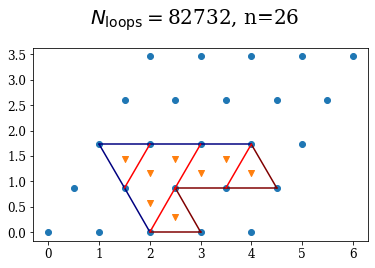

time: 218 ms (started: 2022-10-25 16:57:12 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
n_loop = 26
for eb in [All_loops[n_loop]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")
  fig.suptitle(r"$N_{\rm loops}=$" + f"{len(All_loops)}, " + f"n={n_loop}", fontsize=20)

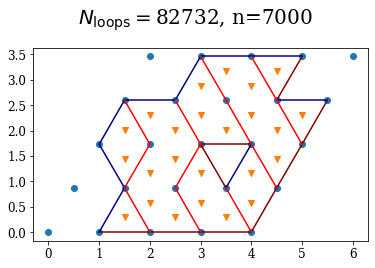

time: 219 ms (started: 2022-10-25 16:57:12 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
n_loop=7000
for eb in [All_loops[n_loop]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")
  fig.suptitle(r"$N_{\rm loops}=$" + f"{len(All_loops)}, " + f"n={n_loop}", fontsize=20)  

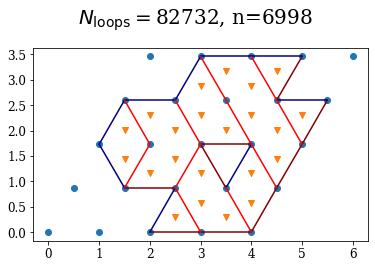

time: 217 ms (started: 2022-10-25 16:57:13 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
n_loop=6998
for eb in [All_loops[n_loop]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")
  fig.suptitle(r"$N_{\rm loops}=$" + f"{len(All_loops)}, " + f"n={n_loop}", fontsize=20)  

#### Elementary bonds only 
 - Optimize energy functional

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds))
energy_Q = lambda Q0: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

time: 1.34 ms (started: 2023-01-10 19:00:46 +00:00)


In [ ]:
Q0 = 0.1
results_gs = minimize(energy_Q, Q0)

time: 39 ms (started: 2023-01-10 19:00:47 +00:00)


In [ ]:
pickle.dump(results_gs, open(data_dir + "results_gs.p", 'wb'))

time: 9.08 ms (started: 2023-01-10 19:00:48 +00:00)


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-21.77777777777778
True
Optimization terminated successfully.
0


array([0.88191709])

time: 9.57 ms (started: 2023-01-10 18:54:14 +00:00)


In [ ]:
height = np.sqrt(3)/2
visonBonds_vs = [np.array([[3.5, height], [3., 2. * height]]),
                 np.array([[3.5, height], [4., 2. * height]]), 
              np.array([[4., 2. * height], [4.5, height]]), 
              np.array([[4.5, height], [5., 2 *height]])]
visonBonds_idx = []
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  visonBonds_idx.append(idx)

time: 2.6 ms (started: 2023-01-10 19:18:24 +00:00)


##### optimization with sign bounds

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] * np.ones(len(bonds))
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_init), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 3762, CG iterations: 185, optimality: 3.97e-07, constraint violation: 0.00e+00, execution time: 1.1e+01 s.
time: 10.7 s (started: 2023-01-10 19:37:15 +00:00)


In [ ]:
energy_Q(Q_init)

-19.962963061911402

time: 16.6 ms (started: 2023-01-10 19:37:26 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-20.565681722657665
True
`xtol` termination condition is satisfied.
2


array([ 0.77131567,  0.77131567,  0.83603808,  0.83239885,  0.87102181,
        0.81725455,  0.87637134,  0.87108359,  0.80846173,  0.77933024,
        0.7749425 ,  0.81286837,  0.82078343,  0.87187562,  0.8379901 ,
        0.91557595,  0.88459264,  0.92162218,  0.69987885,  0.8585264 ,
        0.76363323,  0.86491262, -0.75429468, -0.84362606, -0.87288552,
       -0.83963971,  0.88900737,  0.8457347 ,  0.86690226,  0.88887739,
        0.92727137,  0.86831193,  0.9353304 ,  0.93852946,  0.8901905 ,
        0.93797518,  0.93623857,  0.89012428,  0.83970767,  0.8877345 ,
        0.83818414,  0.93666017,  0.84097129,  0.89287094,  0.93756882,
        0.89496618,  0.89677016,  0.87407424,  0.89218507,  0.87439488,
        0.83432491,  0.77170969,  0.83904832,  0.8489195 ,  0.84032315,
        0.77170971])

time: 18.9 ms (started: 2023-01-10 19:37:26 +00:00)


In [ ]:
pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 9.72 ms (started: 2023-01-10 19:37:26 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 1.73 ms (started: 2023-01-10 19:37:26 +00:00)


In [ ]:
Qv_results - Q0_results

array([-0.11060142, -0.11060143, -0.04587901, -0.04951824, -0.01089528,
       -0.06466254, -0.00554575, -0.0108335 , -0.07345536, -0.10258685,
       -0.10697459, -0.06904872, -0.06113366, -0.01004148, -0.043927  ,
        0.03365885,  0.00267555,  0.03970509, -0.18203825, -0.0233907 ,
       -0.11828386, -0.01700448, -1.63621177, -1.72554315, -1.75480261,
       -1.7215568 ,  0.00709028, -0.03618239, -0.01501483,  0.0069603 ,
        0.04535428, -0.01360517,  0.05341331,  0.05661236,  0.00827341,
        0.05605809,  0.05432148,  0.00820719, -0.04220942,  0.00581741,
       -0.04373296,  0.05474308, -0.0409458 ,  0.01095385,  0.05565172,
        0.01304909,  0.01485307, -0.00784285,  0.01026798, -0.00752221,
       -0.04759218, -0.1102074 , -0.04286877, -0.03299759, -0.04159394,
       -0.11020738])

time: 6.28 ms (started: 2023-01-10 19:37:26 +00:00)


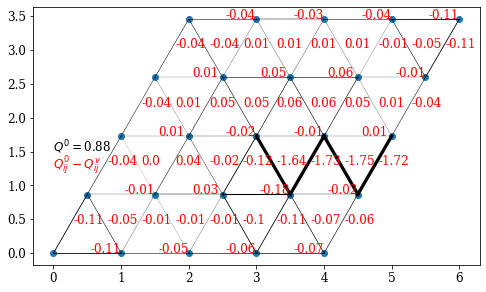

time: 781 ms (started: 2023-01-10 19:37:26 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Qv_results, c='k', p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 1.5))
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

time: 798 ms (started: 2023-01-10 19:37:26 +00:00)


##### optimization v1

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] * np.ones(len(bonds))
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_minimize.py:538: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


time: 273 ms (started: 2023-01-10 18:54:22 +00:00)


In [ ]:
energy_Q(Q_init)

-19.962963061911402

time: 9.66 ms (started: 2023-01-10 18:54:32 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-20.534718654745276
False
Maximum number of iterations has been exceeded.
1


array([ 0.79255443,  0.79255443,  0.84067283,  0.84067283,  0.88879116,
        0.84067283,  0.88879116,  0.88879116,  0.84067283,  0.79255443,
        0.79255443,  0.84067283,  0.84067283,  0.88879116,  0.84067283,
        0.93690956,  0.88879116,  0.93690956,  0.7444361 ,  0.84067283,
        0.7444361 ,  0.88879116, -0.7444361 , -0.84067283, -0.88879123,
       -0.84067283,  0.88879116,  0.84067283,  0.84067283,  0.88879116,
        0.93690956,  0.84067283,  0.93690956,  0.93690956,  0.88879116,
        0.93690956,  0.93690956,  0.88879116,  0.84067283,  0.88879116,
        0.84067283,  0.93690956,  0.84067283,  0.88879116,  0.93690956,
        0.88879116,  0.88879116,  0.88879116,  0.88879116,  0.88879116,
        0.84067283,  0.79255443,  0.84067283,  0.84067283,  0.84067283,
        0.79255443])

time: 11.8 ms (started: 2023-01-10 18:54:33 +00:00)


In [ ]:
pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 378 ms (started: 2023-01-10 18:54:34 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 789 µs (started: 2023-01-10 18:54:36 +00:00)


In [ ]:
Qv_results - Q0_results

array([-0.08936266, -0.08936266, -0.04124427, -0.04124427,  0.00687407,
       -0.04124427,  0.00687407,  0.00687407, -0.04124427, -0.08936266,
       -0.08936266, -0.04124427, -0.04124427,  0.00687407, -0.04124427,
        0.05499246,  0.00687407,  0.05499246, -0.13748099, -0.04124427,
       -0.13748099,  0.00687407, -1.62635319, -1.72258992, -1.77070832,
       -1.72258992,  0.00687407, -0.04124427, -0.04124427,  0.00687407,
        0.05499246, -0.04124427,  0.05499246,  0.05499246,  0.00687407,
        0.05499246,  0.05499246,  0.00687407, -0.04124427,  0.00687407,
       -0.04124427,  0.05499246, -0.04124427,  0.00687407,  0.05499246,
        0.00687407,  0.00687407,  0.00687407,  0.00687407,  0.00687407,
       -0.04124427, -0.08936266, -0.04124427, -0.04124427, -0.04124427,
       -0.08936266])

time: 4.91 ms (started: 2023-01-10 18:54:37 +00:00)


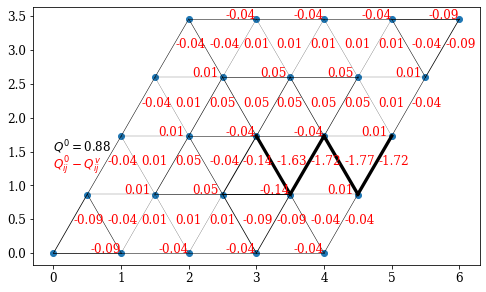

time: 604 ms (started: 2023-01-10 18:54:38 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Qv_results, c='k', p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 1.5))
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

## Test - larger grid

In [ ]:
def create_grid_mesh(params):
  """
  Create a mesh grid of the regtangular grid (nx, ny) (in units of lattice vectors v = nx a_x + ny a_y)
  """
  kx1 = params['x1']
  kx2 = params['x2']
  ky1 = params['y1']
  ky2 = params['y2']
  Nx = params['Nx']
  Ny = params['Ny']
  origin_shift = params['O']

  spacing_x = (kx2 - kx1) / (Nx)
  spacing_y = (ky2 - ky1) / (Ny)
  kx_grid = np.linspace(kx1, kx2 - spacing_x, Nx) + origin_shift[0]   #x grid with shift of ny (not y!)
  ky_grid = np.linspace(ky1, ky2 - spacing_y, Ny) + origin_shift[1]

  #create a mesh
  X, Y = np.meshgrid(kx_grid, ky_grid)

  return X, Y

def create_grid(params):
  """
  Create a mesh grid of the lattice grid (vx, vy) 
  """
  #create a mesh
  my_x, my_y = create_grid_mesh(params)
  a1 = params['a1']
  a2 = params['a2']
  #stack the mesh to (Nx, Ny, d=2) dim
  # print(my_x.shape)
  # my_grid = np.stack([my_x * a1 + my_y * a2], axis=-1)
  my_grid = np.stack([my_x, my_y], axis=-1)
  # print(my_grid.shape)

  my_grid = einops.rearrange(my_grid, 'x y d -> (x y) d') #integer grid

  return np.tensordot(my_grid[:, 0], a1, 0) + np.tensordot(my_grid[:, 1], a2, 0)

time: 6.17 ms (started: 2023-01-10 18:53:36 +00:00)


In [ ]:
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.)}
create_grid_mesh(grid_params)
BZ_kpoints = create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

time: 19.3 ms (started: 2023-01-10 19:51:02 +00:00)


Text(0.5, 0.98, 'Lattice with N=64 and $N_{\\rm bonds}=$161')

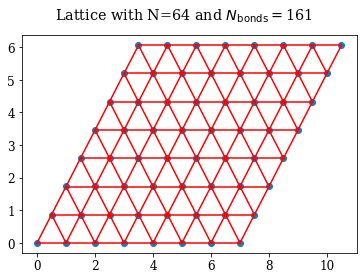

time: 728 ms (started: 2023-01-10 19:42:35 +00:00)


In [ ]:
# find all bonds
my_points = close_pairs_pdist(BZ_kpoints, 1.1)
bonds = BZ_kpoints[np.stack(my_points).T]
bonds = np.around(bonds, 2)

fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
_plot_v_bonds(ax, bonds, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds.shape[0]}")


In [ ]:
bonds_dict = build_dict_bonds(bonds)

time: 1.29 ms (started: 2023-01-10 19:42:39 +00:00)


In [ ]:
test_key = np.around((np.array([[2., 0.], [1., 0.]])), 2)
print(test_key)
bonds_dict[test_key.tobytes()]

[[2. 0.]
 [1. 0.]]


2

time: 7.45 ms (started: 2023-01-10 19:42:40 +00:00)


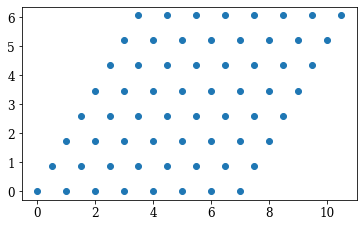

time: 173 ms (started: 2023-01-10 19:42:42 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")


### Loops - large grid

In [ ]:
data_dir = '/content/drive/MyDrive/Projects/RydbergVison/Data/DataColab/'

time: 779 µs (started: 2023-01-10 19:42:47 +00:00)


#### Create elementry bonds

In [ ]:
#@title create all elementry bonds
grid_params_eb = {'x1':0, 'x2':nx-1, 'y1':0, 'y2':ny-1, 'Nx':nx-1, 'Ny':ny-1, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 0.)}
points_eb1 = list(create_grid(grid_params_eb))
grid_params_eb0 = {'x1':0, 'x2':6, 'y1':0, 'y2':7, 'Nx':6, 'Ny':7, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(1., 0.)}
points_eb0 = list(create_grid(grid_params_eb0))
grid_params_eb2 = {'x1':0, 'x2':nx-1, 'y1':0, 'y2':ny-2, 'Nx':nx-1, 'Ny':ny-2, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 1.)}
points_eb2 = list(create_grid(grid_params_eb2))
ListEBs0 = [elemetntaryLoop(0, p) for p in points_eb0]
ListEBs1 = [elemetntaryLoop(1, p) for p in points_eb1]
ListEBs2 = [elemetntaryLoop(2, p) for p in points_eb2]
ListEB_comb = [ListEBs0, ListEBs1, ListEBs2]
ListEBs = sum(ListEB_comb, [])

time: 23.9 ms (started: 2023-01-10 19:51:57 +00:00)


In [ ]:
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

time: 2.14 ms (started: 2023-01-10 19:51:57 +00:00)


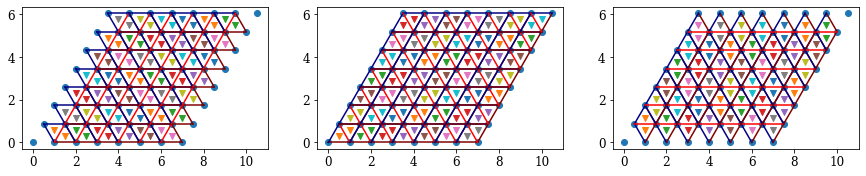

time: 2.77 s (started: 2023-01-10 19:51:57 +00:00)


In [ ]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    _plot_v_bonds(ax, bd_vs, c=c)
    _plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Elementary bonds only 
 - Optimize energy functional

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds))
energy_Q = lambda Q0: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

time: 1.42 ms (started: 2023-01-10 20:10:46 +00:00)


In [ ]:
Q0 = 0.1
results_gs = minimize(energy_Q, Q0)

time: 94.2 ms (started: 2023-01-10 20:10:47 +00:00)


In [ ]:
# pickle.dump(results_gs, open(data_dir + "results_gs.p", 'wb'))

time: 7.94 ms (started: 2023-01-10 20:10:48 +00:00)


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-68.57407407407405
True
Optimization terminated successfully.
0


array([0.92295821])

time: 8.1 ms (started: 2023-01-10 20:10:49 +00:00)


In [ ]:
height = np.sqrt(3)/2
visonBonds_vs = [np.array([[5.5, 3 * height], [5., 4 * height]]),
                 np.array([[5.5, 3 * height], [6., 4. * height]]), 
              np.array([[6., 4. * height], [6.5,  3 * height]]), 
              np.array([[6.5,  3 * height], [7., 4 *height]]), 
              np.array([[7., 4 *height], [7.5, 3 * height]]),
              np.array([[7.5,  3 * height], [8., 4 *height]]), 
              np.array([[8., 4 *height], [8.5, 3 * height]]),
              np.array([[8.5,  3 * height], [9., 4 *height]])
              ]
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

time: 3.91 ms (started: 2023-01-10 20:10:50 +00:00)


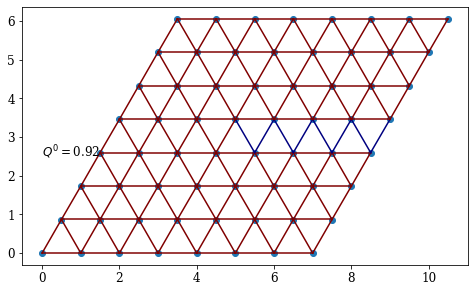

time: 462 ms (started: 2023-01-10 20:10:51 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

##### optimization with sign bounds

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] * np.ones(len(bonds))
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 203, function evaluations: 44712, CG iterations: 3741, optimality: 1.81e-06, constraint violation: 0.00e+00, execution time: 2.5e+02 s.
time: 4min 15s (started: 2023-01-10 20:13:25 +00:00)


In [ ]:
energy_Q(Q_init)

-66.39711929866053

time: 17.2 ms (started: 2023-01-10 20:17:51 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-68.05621548113353
True
`xtol` termination condition is satisfied.
2


array([ 0.77195798,  0.77195802,  0.84189872,  0.83538574,  0.87598534,
        0.85341187,  0.89653724,  0.90228858,  0.85516939,  0.90675452,
        0.90756647,  0.85489666,  0.90764612,  0.90753289,  0.85362197,
        0.90660023,  0.90616746,  0.84213053,  0.90202103,  0.89929395,
        0.84534872,  0.8422192 ,  0.87598539,  0.84189871,  0.94913721,
        0.89653728,  0.94913727,  0.96125721,  0.96710795,  0.9749868 ,
        0.96082366,  0.97750231,  0.97709597,  0.95841057,  0.97124686,
        0.96969155,  0.95448753,  0.9688635 ,  0.96811358,  0.89973576,
        0.96723209,  0.95544961,  0.90262951,  0.8541007 ,  0.90228864,
        0.85341194,  0.97498689,  0.90675456,  0.96125724,  0.98286724,
        0.97750229,  0.98286721,  0.96241285,  0.9747969 ,  0.95975933,
        0.96125199,  0.88425885,  0.88378717,  0.97313481,  0.95880469,
        0.97171686,  0.90740882,  0.97537943,  0.96154193,  0.90791069,
        0.85553013,  0.90756645,  0.85516946,  0.97709599,  0.90

time: 13.3 ms (started: 2023-01-10 20:17:52 +00:00)


In [ ]:
# pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 397 µs (started: 2023-01-10 20:17:55 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 1.11 ms (started: 2023-01-10 20:17:57 +00:00)


Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

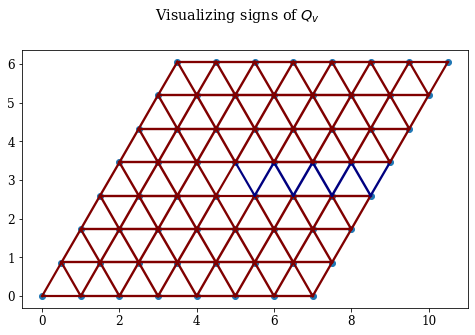

time: 1 s (started: 2023-01-10 20:31:46 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [ ]:
Qv_results - Q0_results

array([-0.15100023, -0.15100019, -0.08105949, -0.08757247, -0.04697287,
       -0.06954634, -0.02642097, -0.02066963, -0.06778882, -0.01620369,
       -0.01539175, -0.06806156, -0.01531209, -0.01542532, -0.06933624,
       -0.01635799, -0.01679076, -0.08082768, -0.02093718, -0.02366426,
       -0.07760949, -0.08073901, -0.04697282, -0.0810595 ,  0.02617899,
       -0.02642093,  0.02617905,  0.038299  ,  0.04414974,  0.05202859,
        0.03786545,  0.0545441 ,  0.05413776,  0.03545236,  0.04828865,
        0.04673333,  0.03152931,  0.04590529,  0.04515537, -0.02322245,
        0.04427388,  0.0324914 , -0.0203287 , -0.06885751, -0.02066957,
       -0.06954627,  0.05202868, -0.01620365,  0.03829903,  0.05990903,
        0.05454408,  0.059909  ,  0.03945463,  0.05183868,  0.03680112,
        0.03829377, -0.03869936, -0.03917104,  0.0501766 ,  0.03584648,
        0.04875864, -0.0155494 ,  0.05242121,  0.03858372, -0.01504752,
       -0.06742808, -0.01539176, -0.06778875,  0.05413778, -0.01

time: 10.1 ms (started: 2023-01-10 20:17:59 +00:00)


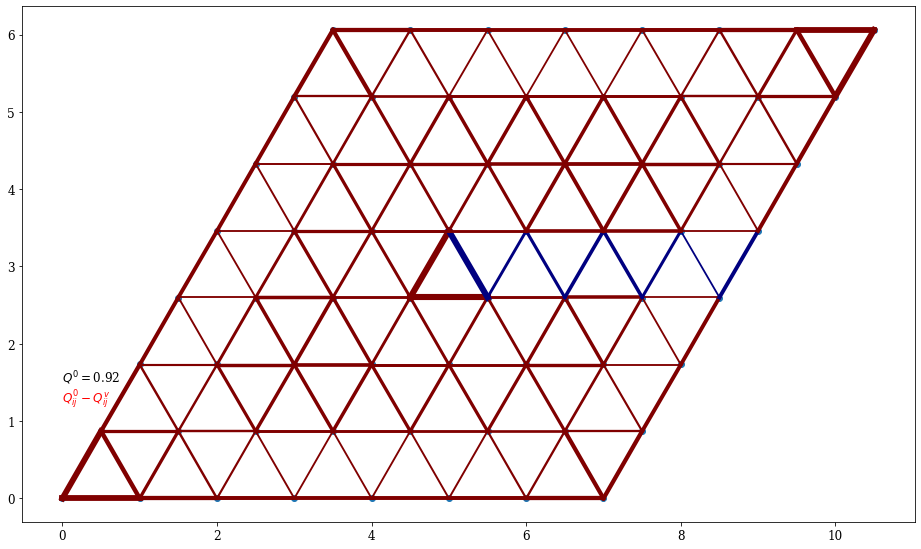

time: 981 ms (started: 2023-01-10 20:28:27 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=15)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 1.5))
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

time: 1.29 s (started: 2023-01-10 20:12:48 +00:00)


## Test - larger grid (cut for hexagon)

In [ ]:
def create_grid_mesh(params):
  """
  Create a mesh grid of the regtangular grid (nx, ny) (in units of lattice vectors v = nx a_x + ny a_y)
  """
  kx1 = params['x1']
  kx2 = params['x2']
  ky1 = params['y1']
  ky2 = params['y2']
  Nx = params['Nx']
  Ny = params['Ny']
  origin_shift = params['O']

  spacing_x = (kx2 - kx1) / (Nx)
  spacing_y = (ky2 - ky1) / (Ny)
  kx_grid = np.linspace(kx1, kx2 - spacing_x, Nx) + origin_shift[0]   #x grid with shift of ny (not y!)
  ky_grid = np.linspace(ky1, ky2 - spacing_y, Ny) + origin_shift[1]

  #create a mesh
  X, Y = np.meshgrid(kx_grid, ky_grid)

  return X, Y

def create_grid(params):
  """
  Create a mesh grid of the lattice grid (vx, vy) 
  """
  #create a mesh
  my_x, my_y = create_grid_mesh(params)
  a1 = params['a1']
  a2 = params['a2']
  #stack the mesh to (Nx, Ny, d=2) dim
  # print(my_x.shape)
  # my_grid = np.stack([my_x * a1 + my_y * a2], axis=-1)
  my_grid = np.stack([my_x, my_y], axis=-1)
  # print(my_grid.shape)

  my_grid = einops.rearrange(my_grid, 'x y d -> (x y) d') #integer grid

  return np.tensordot(my_grid[:, 0], a1, 0) + np.tensordot(my_grid[:, 1], a2, 0)

def convert_to_XY(
    pts: Array)-> Tuple[Array]:
  return zip((pts[:, 0], pts[:, 1]))

time: 4.91 ms (started: 2023-01-11 21:56:52 +00:00)


In [ ]:
nx = 8
ny = 8
grid_params = {'x1':0, 'x2':nx, 'y1':0, 'y2':ny, 'Nx':nx, 'Ny':ny, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0.,0.)}
create_grid_mesh(grid_params)
BZ_kpoints = create_grid(grid_params)
my_x, my_y = zip((BZ_kpoints[:, 0], BZ_kpoints[:, 1]))

time: 14 ms (started: 2023-01-11 21:47:19 +00:00)


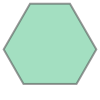

time: 30.9 ms (started: 2023-01-11 21:50:56 +00:00)


In [ ]:
# Define the polygon for the cut
height = np.sqrt(3)/2
epsilon = 0.01 # to shift the boundary of the polygon slightly so that the region counts correct points within the boundary
polygon = Polygon([(3 - epsilon, 0 - epsilon), (7 + epsilon, 0 - epsilon), (8.5 + epsilon, 3 * height + epsilon), 
                   (6.5 + epsilon, 7 * height + epsilon), (3.5 - epsilon, 7 * height + epsilon), (1.5 - epsilon, 3 * height + epsilon)])
polygon

In [ ]:
def get_contained_pts_poly(
    pts: Array, 
    poly: Any)-> Array:
  '''
  Util function getting points contained in `polygon` from an array of points `pts`.
  '''
  pts_cut = []
  # check if points live in the polygon region
  for i, pt in enumerate(list(pts)):
    # print(pt.shape)
    poly_pt = shapely.Point(pt)
    if polygon.contains(poly_pt):
      pts_cut.append(pt)
  return np.stack(pts_cut, 0)

BZ_kpoints_cut = get_contained_pts_poly(BZ_kpoints, polygon)

time: 12.1 ms (started: 2023-01-11 22:16:49 +00:00)


Text(0.5, 0.98, 'Lattice with N=48 and $N_{\\rm bonds}=$120')

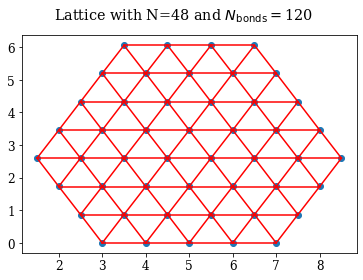

time: 905 ms (started: 2023-01-11 22:16:50 +00:00)


In [ ]:
def _find_all_bonds(pts, cut_off=1.1):
  # utility function to find all bonds given all points `pts`
  my_points = close_pairs_pdist(pts, 1.1)
  bonds = pts[np.stack(my_points).T]
  return np.around(bonds, 2)

bonds = _find_all_bonds(BZ_kpoints_cut)
fig, ax = plt.subplots(1,1)
# my_x, my_y = zip((np.stack(BZ_kpoints_cut, 0)[:, 0], np.stack(BZ_kpoints_cut, 0)[:, 1]))
ax.scatter(my_x, my_y)
ax.set_aspect("equal")
_plot_v_bonds(ax, bonds, c='r')
fig.suptitle(f"Lattice with N={my_x[0].shape[0]} and " +r"$N_{\rm bonds}=$" + f"{bonds.shape[0]}")


In [ ]:
bonds_dict = build_dict_bonds(bonds)

time: 1.5 ms (started: 2023-01-11 22:16:51 +00:00)


In [ ]:
# test_key = np.around((np.array([[2., 0.], [1., 0.]])), 2)
# print(test_key)
# bonds_dict[test_key.tobytes()]

time: 482 µs (started: 2023-01-11 22:16:51 +00:00)


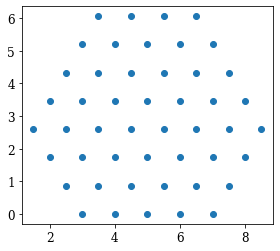

time: 254 ms (started: 2023-01-11 22:16:52 +00:00)


In [ ]:
fig, ax = plt.subplots(1,1)
my_x, my_y = convert_to_XY(BZ_kpoints_cut)
ax.scatter(my_x, my_y)
ax.set_aspect("equal")


### Loops - large grid

In [ ]:
data_dir = '/content/drive/MyDrive/Projects/RydbergVison/Data/DataColab/'

time: 779 µs (started: 2023-01-10 19:42:47 +00:00)


#### Create elementry bonds

In [ ]:
int(3.5)

3

time: 10.2 ms (started: 2023-01-11 22:25:35 +00:00)


In [ ]:
#@title create all elementry bonds

# Redefine the polygon for boundary conditions
height = np.sqrt(3)/2
epsilon = 0.01 # to shift the boundary of the polygon slightly so that the region counts correct points within the boundary
polygon = Polygon([(int((nx-1)/2) - epsilon, 0 - epsilon), 
                   ((nx-1) + epsilon, 0 - epsilon), 
                   (int((nx-1)/2)/2 + (nx-1) - 1 - epsilon, int((nx-1)/2) * height - epsilon), 
                   ((nx-1)/2 + int((nx-1)/2) - 1 - epsilon, (nx-1) * height - epsilon), 
                   ((nx-1)/2 - epsilon, (nx-1) * height + epsilon), 
                   (int((nx-1)/2)/2  - epsilon, int((nx-1)/2) * height + epsilon)])

grid_params_eb1 = {'x1':0, 'x2':nx-1, 'y1':0, 'y2':ny-1, 'Nx':nx-1, 'Ny':ny-1, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 0.)}
points_eb1 = list(create_grid(grid_params_eb1))
points_eb1 = get_contained_pts_poly(points_eb1, polygon)

# Redefine the polygon for boundary conditions
polygon = Polygon([(int((nx-1)/2) - epsilon, 0 - epsilon), 
                   ((nx-1) + epsilon, 0 - epsilon), 
                   (int((nx-1)/2)/2 + (nx-1) - epsilon, int((nx-1)/2) * height - epsilon), 
                   ((nx-1)/2 + int((nx-1)/2) - epsilon, (nx-1) * height - epsilon), 
                   ((nx-1)/2 - epsilon, (nx-1) * height + epsilon), 
                   (int((nx-1)/2)/2  - epsilon, int((nx-1)/2) * height + epsilon)])


grid_params_eb0 = {'x1':0, 'x2':6, 'y1':0, 'y2':7, 'Nx':6, 'Ny':7, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(1., 0.)}
points_eb0 = list(create_grid(grid_params_eb0))
points_eb0 = get_contained_pts_poly(points_eb0, polygon)

grid_params_eb2 = {'x1':0, 'x2':nx-1, 'y1':0, 'y2':ny-2, 'Nx':nx-1, 'Ny':ny-2, 'a1':np.array([1,0]), 'a2':np.array([1/2, np.sqrt(3)/2]), 'O':(0., 1.)}
points_eb2 = list(create_grid(grid_params_eb2))
points_eb2 = get_contained_pts_poly(points_eb2, polygon)
ListEBs0 = [elemetntaryLoop(0, p) for p in points_eb0]
ListEBs1 = [elemetntaryLoop(1, p) for p in points_eb1]
ListEBs2 = [elemetntaryLoop(2, p) for p in points_eb2]
ListEB_comb = [ListEBs0, ListEBs1, ListEBs2]
ListEBs = sum(ListEB_comb, [])

time: 46.6 ms (started: 2023-01-11 22:31:20 +00:00)


In [ ]:
num_ebs_list = [len(ebs) for ebs in ListEB_comb]
total_num_EBs = len(ListEBs)

time: 1.08 ms (started: 2023-01-11 22:31:21 +00:00)


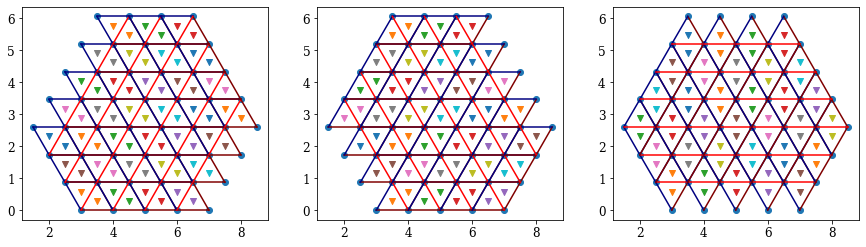

time: 2.42 s (started: 2023-01-11 22:31:21 +00:00)


In [ ]:
fig, axes = plt.subplots(1,3, figsize = (3 * 5, 5))

for i, ebs in enumerate(ListEB_comb):
  ax = axes[i]
  ax.scatter(my_x, my_y)
  for j, eb in enumerate(ebs):
    triangles = np.split(eb['triangles'], 2, axis=1)
    bd_vs = eb['bd_vs']
    mid_vs = eb['mid_vs']
    bd_signs = eb['bd_signs']
    
    colors = plt.cm.jet(np.linspace(0,1,2))
    bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
    # print(bd_signs_idx)
    c = colors[bd_signs_idx]
    ax.scatter(triangles[0], triangles[1], marker='v')
    _plot_v_bonds(ax, bd_vs, c=c)
    _plot_v_bonds(ax, mid_vs, c='r')
    ax.set_aspect("equal")

#### Elementary bonds only 
- Optimize energy functional

In [ ]:
couplings = {'alpha':1, "beta":-10, "K":-0.5}
Q_init = np.ones(len(bonds))
energy_Q = lambda Q0: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

time: 1.44 ms (started: 2023-01-11 22:54:58 +00:00)


In [ ]:
Q0 = 0.0001
results_gs = minimize(energy_Q, Q0)

time: 144 ms (started: 2023-01-11 22:54:59 +00:00)


In [ ]:
# pickle.dump(results_gs, open(data_dir + "results_gs.p", 'wb'))

time: 490 µs (started: 2023-01-11 22:55:00 +00:00)


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-6.539509536784732
True
Optimization terminated successfully.
0


array([0.33013909])

time: 10.1 ms (started: 2023-01-11 22:55:00 +00:00)


In [ ]:
height = np.sqrt(3)/2
visonBonds_vs = [np.array([[5.5, 3 * height], [5., 4 * height]]),
                 np.array([[5.5, 3 * height], [6., 4. * height]]), 
              np.array([[6., 4. * height], [6.5,  3 * height]]), 
              np.array([[6.5,  3 * height], [7., 4 *height]]), 
              np.array([[7., 4 *height], [7.5, 3 * height]]),
              np.array([[7.5,  3 * height], [8., 4 *height]]), 
              np.array([[8., 4 *height], [8.5, 3 * height]]),
              ]
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

time: 5.8 ms (started: 2023-01-11 22:55:00 +00:00)


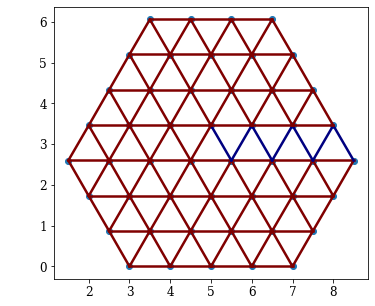

time: 338 ms (started: 2023-01-11 22:55:02 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

##### optimization with sign bounds
 - $K<0$ $\rightarrow$ $0$-flux state

In [ ]:
couplings = {'alpha':1, "beta":-10, "K":-0.5}
Q_init = results_gs['x'] * np.ones(len(bonds))
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 13673, CG iterations: 433, optimality: 2.31e-08, constraint violation: 0.00e+00, execution time: 5.5e+01 s.
time: 55.1 s (started: 2023-01-11 22:55:07 +00:00)


In [ ]:
energy_Q(Q_init)

-6.503871885811399

time: 16.2 ms (started: 2023-01-11 22:56:02 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-6.508122251193718
True
`xtol` termination condition is satisfied.
2


array([ 0.32471498,  0.324715  ,  0.3247649 ,  0.32487084,  0.32880751,
        0.32885564,  0.32487083,  0.32890687,  0.32890687,  0.32471498,
        0.32885563,  0.32880752,  0.3247649 ,  0.324715  ,  0.32880796,
        0.32486839,  0.328855  ,  0.33285494,  0.33285758,  0.33309199,
        0.33290454,  0.33309433,  0.33309567,  0.33285494,  0.33309567,
        0.33309432,  0.32880797,  0.33309198,  0.33285757,  0.328855  ,
        0.32486838,  0.32885501,  0.324715  ,  0.32880797,  0.33318474,
        0.3328576 ,  0.33318474,  0.33291505,  0.33310132,  0.33282886,
        0.33291504,  0.32536314,  0.32536313,  0.33318473,  0.33282885,
        0.33310131,  0.328855  ,  0.33318475,  0.33285757,  0.32880797,
        0.324715  ,  0.32476491,  0.32471497,  0.333092  ,  0.32880752,
        0.33285494,  0.33282885,  0.33309432,  0.33291505,  0.31685317,
        0.32536314,  0.31685317,  0.33282884, -0.31685316, -0.32536315,
        0.333092  , -0.33291503, -0.33309433,  0.3247649 , -0.33

time: 16.1 ms (started: 2023-01-11 22:56:02 +00:00)


time: 36.2 ms (started: 2023-01-11 22:56:02 +00:00)


In [ ]:
# pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 443 µs (started: 2023-01-11 22:56:02 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 782 µs (started: 2023-01-11 22:56:02 +00:00)


Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

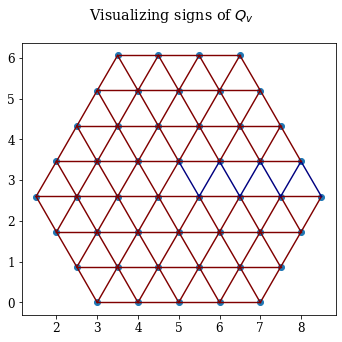

time: 380 ms (started: 2023-01-11 22:56:02 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [ ]:
Qv_results - Q0_results

array([-0.00542411, -0.00542409, -0.00537419, -0.00526825, -0.00133158,
       -0.00128345, -0.00526826, -0.00123223, -0.00123222, -0.00542411,
       -0.00128346, -0.00133157, -0.00537419, -0.00542409, -0.00133113,
       -0.00527071, -0.00128409,  0.00271585,  0.00271849,  0.0029529 ,
        0.00276544,  0.00295524,  0.00295658,  0.00271585,  0.00295658,
        0.00295523, -0.00133113,  0.00295289,  0.00271848, -0.00128409,
       -0.00527071, -0.00128408, -0.00542409, -0.00133112,  0.00304565,
        0.00271851,  0.00304565,  0.00277595,  0.00296223,  0.00268976,
        0.00277595, -0.00477596, -0.00477596,  0.00304564,  0.00268976,
        0.00296222, -0.00128409,  0.00304566,  0.00271848, -0.00133113,
       -0.00542409, -0.00537419, -0.00542412,  0.0029529 , -0.00133158,
        0.00271585,  0.00268976,  0.00295523,  0.00277595, -0.01328592,
       -0.00477595, -0.01328592,  0.00268975, -0.64699226, -0.65550224,
        0.00295291, -0.66305413, -0.66323342, -0.00537419, -0.66

time: 5.09 ms (started: 2023-01-11 22:56:02 +00:00)


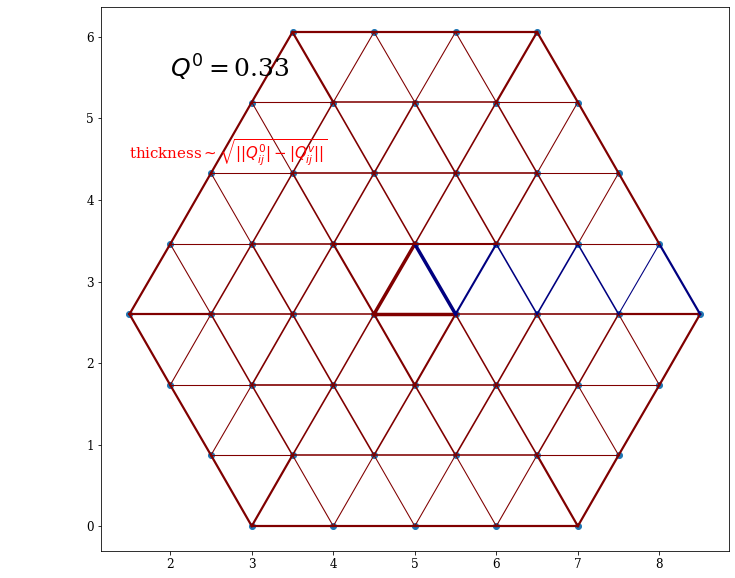

time: 868 ms (started: 2023-01-11 23:01:44 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

time: 473 ms (started: 2023-01-11 22:56:02 +00:00)


##### optimization with sign bounds
 - $K>0$

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":0.5}
Q_init = results_gs['x'] * np.ones(len(bonds))
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

/usr/local/lib/python3.8/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`xtol` termination condition is satisfied.
Number of iterations: 154, function evaluations: 26378, CG iterations: 1828, optimality: 1.48e-07, constraint violation: 0.00e+00, execution time: 1.1e+02 s.
time: 1min 47s (started: 2023-01-11 23:08:53 +00:00)


In [ ]:
energy_Q(Q_init)

-11.101128861371377

time: 12.4 ms (started: 2023-01-11 23:10:40 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-21.900304768652134
True
`xtol` termination condition is satisfied.
2


array([ 0.64246398,  0.6426567 ,  0.64565401,  0.64935773,  0.60123623,
        0.60512548,  0.64935774,  0.60757771,  0.60757771,  0.64246399,
        0.60512545,  0.60123619,  0.64565406,  0.64265671,  0.60075593,
        0.65041327,  0.60568526,  0.55352596,  0.55028032,  0.57340668,
        0.55685997,  0.57586139,  0.57529825,  0.55352595,  0.57529825,
        0.5758614 ,  0.60075592,  0.57340668,  0.55028029,  0.60568528,
        0.65041328,  0.60568527,  0.6426567 ,  0.6007559 ,  0.58583597,
        0.55028035,  0.58583599,  0.55619521,  0.57561826,  0.53738371,
        0.55619519,  0.68082535,  0.68082533,  0.58583595,  0.53738371,
        0.57561828,  0.60568526,  0.58583598,  0.55028036,  0.60075586,
        0.64265665,  0.64565399,  0.642464  ,  0.57340665,  0.60123626,
        0.55352596,  0.53738367,  0.57586137,  0.55619524,  0.73966359,
        0.68082536,  0.73966357,  0.53738368, -0.73966362, -0.68082533,
        0.57340669, -0.55619522, -0.57586138,  0.64565404, -0.55

time: 13.7 ms (started: 2023-01-11 23:10:41 +00:00)


time: 32.5 ms (started: 2023-01-11 23:10:41 +00:00)


In [ ]:
# pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 452 µs (started: 2023-01-11 23:10:41 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 1.12 ms (started: 2023-01-11 23:10:41 +00:00)


Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

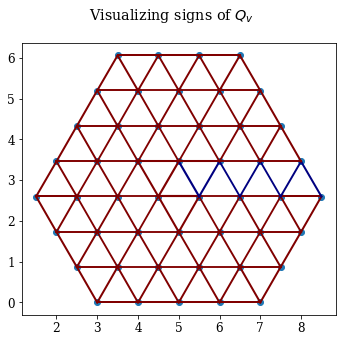

time: 403 ms (started: 2023-01-11 23:10:41 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [ ]:
Qv_results - Q0_results

array([ 0.31232488,  0.31251761,  0.31551491,  0.31921864,  0.27109713,
        0.27498638,  0.31921864,  0.27743862,  0.27743861,  0.31232489,
        0.27498635,  0.2710971 ,  0.31551497,  0.31251762,  0.27061683,
        0.32027418,  0.27554617,  0.22338686,  0.22014123,  0.24326759,
        0.22672088,  0.24572229,  0.24515915,  0.22338685,  0.24515916,
        0.24572231,  0.27061683,  0.24326759,  0.22014119,  0.27554619,
        0.32027419,  0.27554618,  0.31251761,  0.27061681,  0.25569688,
        0.22014126,  0.2556969 ,  0.22605611,  0.24547917,  0.20724462,
        0.22605609,  0.35068625,  0.35068623,  0.25569686,  0.20724462,
        0.24547918,  0.27554617,  0.25569689,  0.22014126,  0.27061677,
        0.31251756,  0.3155149 ,  0.31232491,  0.24326756,  0.27109717,
        0.22338686,  0.20724458,  0.24572227,  0.22605614,  0.4095245 ,
        0.35068627,  0.40952448,  0.20724459, -1.06980271, -1.01096443,
        0.2432676 , -0.88633431, -0.90600047,  0.31551494, -0.88

time: 9.46 ms (started: 2023-01-11 23:10:41 +00:00)


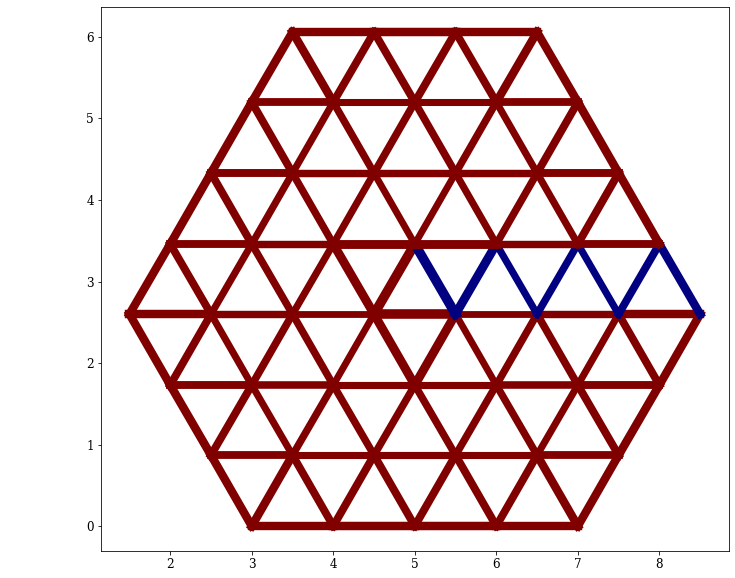

time: 436 ms (started: 2023-01-11 23:10:41 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=15)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 1.5))
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

time: 449 ms (started: 2023-01-11 23:10:41 +00:00)


#### Elementary bonds only 
- Optimize energy functional
- Let $Q^0_{ij}$ to be spatially varying

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.ones(len(bonds))
Q0 = 1.
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)

time: 1.4 ms (started: 2023-01-11 23:14:24 +00:00)


In [ ]:
# Q0 = 0.0001
results_gs = minimize(energy_Q, Q_init)

time: 15 s (started: 2023-01-11 23:14:25 +00:00)


In [ ]:
# pickle.dump(results_gs, open(data_dir + "results_gs.p", 'wb'))

time: 286 µs (started: 2023-01-11 23:14:40 +00:00)


In [ ]:
print(results_gs['fun'])
print(results_gs['success'])
print(results_gs['message'])
print(results_gs['status'])
results_gs['x']

-52.09749812510907
True
Optimization terminated successfully.
0


array([0.84258274, 0.84249974, 0.84581456, 0.85452935, 0.90062265,
       0.90353995, 0.85452943, 0.90789376, 0.9078936 , 0.84258307,
       0.90353979, 0.90062194, 0.84581516, 0.84250009, 0.9001449 ,
       0.85320419, 0.90263504, 0.95805868, 0.95751051, 0.971397  ,
       0.96360764, 0.97908685, 0.98109919, 0.95805853, 0.98109851,
       0.97908682, 0.90014485, 0.97139704, 0.95751041, 0.90263523,
       0.85320405, 0.90263495, 0.8424997 , 0.90014471, 0.97797136,
       0.95751042, 0.97797142, 0.98980559, 0.9885449 , 0.99287835,
       0.98980571, 0.99453593, 0.99453572, 0.9779711 , 0.99287881,
       0.98854557, 0.90263512, 0.97797133, 0.95751042, 0.90014486,
       0.84250002, 0.84581506, 0.842583  , 0.97139719, 0.90062247,
       0.95805867, 0.99287882, 0.97908684, 0.9898055 , 0.99626257,
       0.99453596, 0.99626297, 0.99287901, 0.99626287, 0.99453555,
       0.97139711, 0.98980568, 0.97908709, 0.84581541, 0.95805867,
       0.90062224, 0.84258302, 0.90354001, 0.85452966, 0.98109

time: 11.4 ms (started: 2023-01-11 23:14:40 +00:00)


In [ ]:
height = np.sqrt(3)/2
visonBonds_vs = [np.array([[5.5, 3 * height], [5., 4 * height]]),
                 np.array([[5.5, 3 * height], [6., 4. * height]]), 
              np.array([[6., 4. * height], [6.5,  3 * height]]), 
              np.array([[6.5,  3 * height], [7., 4 *height]]), 
              np.array([[7., 4 *height], [7.5, 3 * height]]),
              np.array([[7.5,  3 * height], [8., 4 *height]]), 
              np.array([[8., 4 *height], [8.5, 3 * height]]),
              ]
visonBonds_idx = []
Q_flip = Q_init
for bd_v in visonBonds_vs:
  bd_v = np.around (bd_v, 2)
  idx = bonds_dict[bd_v.tobytes()]
  Q_flip[idx] = -1
  visonBonds_idx.append(idx)

time: 6.03 ms (started: 2023-01-11 23:14:48 +00:00)


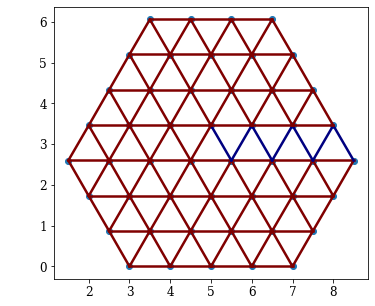

time: 356 ms (started: 2023-01-11 23:14:49 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Q_flip), Q_flip, c=colors[((Q_flip + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

##### optimization with sign bounds
 - $K<0$ $\rightarrow$ $0$-flux state

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = results_gs['x'] 
Q0 = 1.
for idx in visonBonds_idx:
  Q_init[idx] = -1 * Q_init[idx]
energy_Q = lambda Q_init: get_energy(couplings, Q_init, Q0, ListEBs, bonds_dict)
linear_constraint = LinearConstraint(np.diag(Q_flip), np.zeros_like(Q_init), 5* np.ones_like(Q_init))
results_vison = minimize(energy_Q, Q_init, method='trust-constr',
               constraints=linear_constraint,
               options={'verbose': 1})
# results_vison = minimize(energy_Q, Q_init, bounds=einops.repeat(np.array([-10, 5]), 'a -> r a', r=len(Q_init)), options={'maxiter':1}, method="CG")

`xtol` termination condition is satisfied.
Number of iterations: 161, function evaluations: 27709, CG iterations: 1428, optimality: 6.74e-07, constraint violation: 0.00e+00, execution time: 1.2e+02 s.
time: 1min 58s (started: 2023-01-11 23:15:17 +00:00)


In [ ]:
energy_Q(Q_init)

-52.09749812510907

time: 9.89 ms (started: 2023-01-11 23:17:15 +00:00)


In [ ]:
print(results_vison['fun'])
print(results_vison['success'])
print(results_vison['message'])
print(results_vison['status'])
results_vison['x']

-50.09100580274393
True
`xtol` termination condition is satisfied.
2


array([ 0.84203032,  0.84203528,  0.84518325,  0.85342114,  0.89912124,
        0.90181838,  0.85342116,  0.90553477,  0.90553478,  0.84203028,
        0.90181838,  0.89912125,  0.84518323,  0.8420353 ,  0.89908616,
        0.85257487,  0.90151948,  0.95418915,  0.9545964 ,  0.96664614,
        0.95758379,  0.96769688,  0.96825593,  0.95418913,  0.96825594,
        0.96769688,  0.89908616,  0.96664615,  0.9545964 ,  0.90151945,
        0.85257488,  0.90151946,  0.84203529,  0.89908615,  0.97159775,
        0.95459641,  0.97159774,  0.96074251,  0.96985255,  0.95775605,
        0.96074252,  0.88329926,  0.88329929,  0.97159775,  0.95775604,
        0.96985257,  0.90151943,  0.97159776,  0.9545964 ,  0.89908617,
        0.84203528,  0.84518325,  0.84203027,  0.96664615,  0.89912124,
        0.95418912,  0.95775603,  0.96769688,  0.96074251,  0.75716918,
        0.88329923,  0.75716913,  0.95775601, -0.75716911, -0.88329926,
        0.96664615, -0.96074252, -0.96769688,  0.84518322, -0.95

time: 11.7 ms (started: 2023-01-11 23:17:15 +00:00)


In [ ]:
# pickle.dump(results_vison, open(data_dir + "results_vison.p", 'wb'))

time: 435 µs (started: 2023-01-11 23:17:15 +00:00)


In [ ]:
Q0_results = results_gs['x'] * np.ones(len(bonds))
Qv_results = results_vison['x']

time: 2.62 ms (started: 2023-01-11 23:17:15 +00:00)


Text(0.5, 0.98, 'Visualizing signs of $Q_v$')

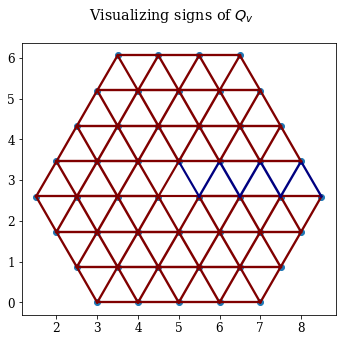

time: 389 ms (started: 2023-01-11 23:17:16 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, np.zeros_like(Qv_results), Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=2.5)
  ax.set_aspect("equal")
  # ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (0., 2.5))
  # ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')
plt.suptitle(f"Visualizing signs of $Q_v$")  

In [ ]:
Qv_results - Q0_results

array([-5.52417589e-04, -4.64460142e-04, -6.31307781e-04, -1.10820564e-03,
       -1.50141036e-03, -1.72157071e-03, -1.10826934e-03, -2.35898221e-03,
       -2.35881149e-03, -5.52785793e-04, -1.72141206e-03, -1.50069512e-03,
       -6.31922213e-04, -4.64787142e-04, -1.05873887e-03, -6.29319214e-04,
       -1.11555734e-03, -3.86952772e-03, -2.91411446e-03, -4.75085864e-03,
       -6.02384585e-03, -1.13899784e-02, -1.28432569e-02, -3.86940435e-03,
       -1.28425718e-02, -1.13899404e-02, -1.05869112e-03, -4.75089122e-03,
       -2.91400886e-03, -1.11577493e-03, -6.29170580e-04, -1.11548600e-03,
       -4.64410950e-04, -1.05855426e-03, -6.37361053e-03, -2.91401395e-03,
       -6.37368691e-03, -2.90630814e-02, -1.86923492e-02, -3.51223059e-02,
       -2.90631877e-02, -1.11236672e-01, -1.11236433e-01, -6.37334271e-03,
       -3.51227763e-02, -1.86929987e-02, -1.11569371e-03, -6.37356300e-03,
       -2.91401607e-03, -1.05868784e-03, -4.64732409e-04, -6.31810416e-04,
       -5.52728118e-04, -

time: 8.35 ms (started: 2023-01-11 23:17:16 +00:00)


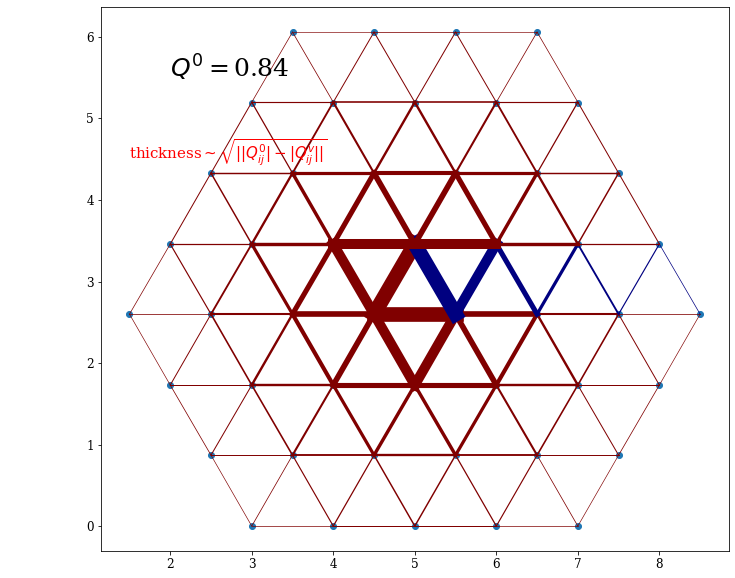

time: 523 ms (started: 2023-01-11 23:18:37 +00:00)


In [ ]:
colors = plt.cm.jet(np.linspace(0,1,2))
fig, ax = plt.subplots(1,1, figsize=(16, 10))
ax.scatter(my_x, my_y)
for bond in [bonds]:
  _plot_visons(ax, bond, Q0_results, Q_flip * Qv_results, c=colors[((np.sign(Qv_results) + 1)/2).astype(int)], p=30)
  ax.set_aspect("equal")
  ax.annotate(r"$Q^0=$" + f"{results_gs['x'][0]:.2f}", (2., 5.5), size=25)
  ax.annotate(f"thickness" + r"$\sim \sqrt{||Q^0_{ij}| - |Q^v_{ij}||}$", (1.5, 4.5), color='r', size = 15)
  ax.annotate(r"$Q^0_{ij} - Q^v_{ij}$", (0., 1.25), color='r')

## scratch


In [ ]:
my_loop = elemetntaryLoop(0, (1/2, np.sqrt(3)/2))
print(my_loop)

{'triangles': array([[0.5       , 1.44337567],
       [1.        , 1.15470054]]), 'bd_vs': array([[[0.5       , 0.8660254 ],
        [1.5       , 0.8660254 ]],

       [[1.5       , 0.8660254 ],
        [1.        , 1.73205081]],

       [[1.        , 1.73205081],
        [0.        , 1.73205081]],

       [[0.        , 1.73205081],
        [0.5       , 0.8660254 ]]]), 'mid_vs': array([[[0.5       , 0.8660254 ],
        [1.        , 1.73205081]]]), 'bs_ps': array([[1.        , 0.8660254 ],
       [1.25      , 1.29903811],
       [0.5       , 1.73205081],
       [0.25      , 1.29903811]]), 'bd_signs': array([ 1,  1, -1, -1])}


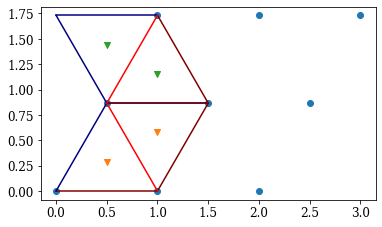

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [ListEBs[0], my_loop]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  
  colors = plt.cm.jet(np.linspace(0,1,2))
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

In [ ]:
cond, merged_loop = check_merge(ListEBs[0], ListEBs[1])

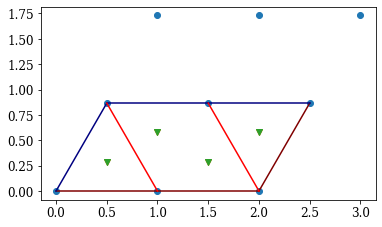

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [merged_loop]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  bd_signs = eb['bd_signs']
  colors = plt.cm.jet(np.linspace(0,1,2))
  
  bd_signs_idx = ((bd_signs + 1.)/2).astype(int)
  # print(bd_signs_idx)
  c = colors[bd_signs_idx]
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs, c=c)
  ax.scatter(triangles[0], triangles[1], marker='v')
  # _plot_v_bonds(ax, bd_vs)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

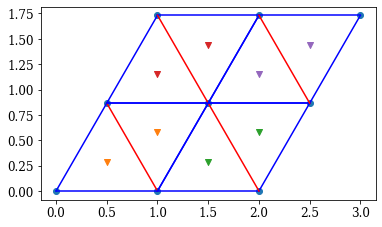

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in ListEBs:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

In [ ]:
All_loops = []
for eb in ListEBs:
  All_loops.append(eb)
  for l in All_loops:
    merge, new_l = check_merge(eb, l)
    if merge:
      All_loops.append(new_l)
    

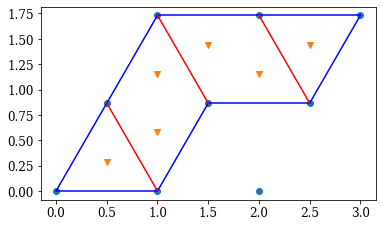

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [All_loops[10]]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  bd_vs = eb['bd_vs']
  mid_vs = eb['mid_vs']
  ax.scatter(triangles[0], triangles[1], marker='v')
  _plot_v_bonds(ax, bd_vs)
  _plot_v_bonds(ax, mid_vs, c='r')
  ax.set_aspect("equal")

In [ ]:
couplings = {'alpha':1, "beta":-2, "K":-0.5}
Q_init = np.arange(len(bonds))
energy_Q = lambda Q0: get_energy(couplings, Q_init, Q0, All_loops, bonds_dict)

In [ ]:
Q_init = np.ones(len(bonds)) 
Q0 = 1
get_energy(couplings, Q_init, Q0, All_loops, bonds_dict)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


1.0

In [ ]:
ListEBs[1]

{'triangles': array([[1.        , 0.57735027],
        [1.5       , 0.28867513]]),
 'boundaries': array([[0.75     , 0.4330127],
        [1.       , 0.8660254],
        [1.5      , 0.       ],
        [1.75     , 0.4330127]]),
 'middle': array([[1.25     , 0.4330127]])}

In [ ]:
a = list(np.around(np.array([[0.75     , 0.4330127],
        [1.       , 0.8660254],
        [1.5      , 0.       ],
        [1.75     , 0.4330127]]), 2))
b = [np.around(np.array([[0.75     , 0.4330127], [1, 1]]),2) ]

In [ ]:
a = np.around(np.array([[0.75     , 0.4330127],
        [1.       , 0.8660254],
        [1.5      , 0.       ],
        [1.75     , 0.4330127]]), 2)
b = np.around(np.array([[0.75     , 0.4330127], [1, 1], [1.5, 0]]),2) 
a2 = einops.repeat(a, 'a b -> a new_axis b ', new_axis=3)
b2 = einops.repeat(b, 'a b -> new_axis a b', new_axis=4)

In [ ]:
def _merge_loops(loop, eb):
  loop_merge = jax.tree_util.tree_map(lambda x, y: np.concatenate([x, y], axis=0), loop, eb)
  bd = loop_merge["boundaries"]
  middle = loop_merge["middle"]
  unq, count = np.unique(bd, axis=0, return_counts=True)
  repeated_ars = unq[count>1]
  for repeated_ar in repeated_ars:
    repeated_idx = np.argwhere(np.all(bd == repeated_ar, axis=1)) 
    bd = np.delete(bd, repeated_idx, axis=0)
    repeated_ar = einops.rearrange(repeated_ar, 'b -> 1 b')
    middle = np.concatenate([middle, repeated_ar], axis=0)
  return {"boundaries": bd, "middle": middle, "triangles": loop_merge["triangles"]}    

In [ ]:
my_loop2 = elemetntaryLoop(0, (2, 0))

In [ ]:
merged_loop = _merge_loops(my_loop, my_loop2)

[[3]
 [4]]


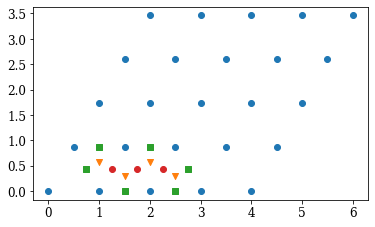

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(my_x, my_y)
for eb in [merged_loop]:
  triangles = np.split(eb['triangles'], 2, axis=1)
  boundaries = np.split(eb['boundaries'], 2, axis=1)
  middle = np.split(eb['middle'], 2, axis=1)
  ax.scatter(triangles[0], triangles[1], marker='v')
  ax.scatter(boundaries[0], boundaries[1], marker='s')
  ax.scatter(middle[0], middle[1], marker='o')
  ax.set_aspect("equal")

In [ ]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
(a2-b2).shape

(4, 3, 2)

In [ ]:
c = a2-b2

In [ ]:
x = np.sum(np.abs(einops.rearrange(c, 'a b c -> (a b)c')), axis=1)

In [ ]:
np.count_nonzero(x)

10

In [ ]:
np.around(0.001, 3)

0.001

In [ ]:
bool(2 %2)

False

In [ ]:
b

array([[0.75, 0.43],
       [1.  , 1.  ],
       [1.5 , 0.  ]])